Imports

In [1]:
from pyspark import SparkContext
import csv
from datetime import datetime
from sklearn.cluster import KMeans
import pandas as pd
from math import sqrt
import numpy as np
from operator import add
import re
import ast
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as spclust
from scipy.spatial import distance
import matplotlib.pyplot as plt

In [2]:
#local spark
sc = SparkContext(appName="Clusters")
#sqlc = SQLContext(sc)
#vocareum
#sc = spark.sparkContext

In [3]:
def read_tracks():
        tracks = pd.read_csv("tracks.csv", index_col=0, header=[0, 1])

        COLUMNS = [('track', 'tags'), ('album', 'tags'), ('artist', 'tags'),
                   ('track', 'genres'), ('track', 'genres_all')]
        for column in COLUMNS:
            tracks[column] = tracks[column].map(ast.literal_eval)

        COLUMNS = [('track', 'date_created'), ('track', 'date_recorded'),
                   ('album', 'date_created'), ('album', 'date_released'),
                   ('artist', 'date_created'), ('artist', 'active_year_begin'),
                   ('artist', 'active_year_end')]
        for column in COLUMNS:
            tracks[column] = pd.to_datetime(tracks[column])

        SUBSETS = ('small', 'medium', 'large')
        try:
            tracks['set', 'subset'] = tracks['set', 'subset'].astype(
                    'category', categories=SUBSETS, ordered=True)
        except (ValueError, TypeError):
            # the categories and ordered arguments were removed in pandas 0.25
            tracks['set', 'subset'] = tracks['set', 'subset'].astype(
                     pd.CategoricalDtype(categories=SUBSETS, ordered=True))

        COLUMNS = [('track', 'genre_top'), ('track', 'license'),
                   ('album', 'type'), ('album', 'information'),
                   ('artist', 'bio')]
        for column in COLUMNS:
            tracks[column] = tracks[column].astype('category')

        return tracks


In [4]:
def read_features():
     return pd.read_csv("features.csv", index_col=0, header=[0, 1, 2])

In [5]:
data = read_tracks()
track_genre_top = data['track','genre_top']

data = data[data['set','subset']=='small']

subset_ids = [i for i in data.index]

In [6]:
#Small sample ids
subset_ids


[2,
 5,
 10,
 140,
 141,
 148,
 182,
 190,
 193,
 194,
 197,
 200,
 203,
 204,
 207,
 210,
 211,
 212,
 213,
 255,
 256,
 368,
 424,
 459,
 534,
 540,
 546,
 574,
 602,
 615,
 620,
 621,
 625,
 666,
 667,
 676,
 690,
 694,
 695,
 704,
 705,
 706,
 707,
 708,
 709,
 714,
 715,
 716,
 718,
 777,
 814,
 821,
 822,
 825,
 853,
 890,
 892,
 897,
 993,
 995,
 997,
 998,
 1039,
 1040,
 1066,
 1069,
 1073,
 1075,
 1082,
 1083,
 1087,
 1102,
 1193,
 1195,
 1196,
 1197,
 1249,
 1259,
 1270,
 1276,
 1277,
 1278,
 1417,
 1427,
 1443,
 1482,
 1510,
 1544,
 1642,
 1644,
 1649,
 1661,
 1663,
 1666,
 1673,
 1680,
 1681,
 1682,
 1683,
 1684,
 1685,
 1686,
 1687,
 1688,
 1689,
 1701,
 1702,
 1703,
 1704,
 1706,
 1720,
 1732,
 1733,
 1735,
 1736,
 1883,
 1891,
 1893,
 1924,
 1925,
 1929,
 1930,
 2012,
 2096,
 2097,
 2099,
 3263,
 3264,
 3265,
 3266,
 3270,
 3271,
 3272,
 3273,
 3274,
 3492,
 3532,
 3533,
 3534,
 3535,
 3537,
 3538,
 3573,
 3598,
 3624,
 3707,
 3708,
 3720,
 3721,
 3722,
 3724,
 3725,
 37

In [8]:
pd_features = read_features()


In [9]:
pd_features


feature    chroma_cens                                                    \
statistics    kurtosis                                                     
number              01        02        03        04        05        06   
track_id                                                                   
2             7.180653  5.230309  0.249321  1.347620  1.482478  0.531371   
3             1.888963  0.760539  0.345297  2.295201  1.654031  0.067592   
5             0.527563 -0.077654 -0.279610  0.685883  1.937570  0.880839   
10            3.702245 -0.291193  2.196742 -0.234449  1.367364  0.998411   
20           -0.193837 -0.198527  0.201546  0.258556  0.775204  0.084794   
...                ...       ...       ...       ...       ...       ...   
155316       -0.490129  0.463834  2.321970 -0.084352  1.662914  2.115189   
155317       -0.461559 -0.229601 -0.496632 -0.422033  0.130612 -0.263825   
155318        0.552473 -0.110498 -0.532014  0.263131 -0.224011 -0.530972   
155319       -0.176901  0.187208 -0.050664  0.368843  0.066005 -0.857354   
155320        0.489665  1.862421  0.854461 -0.103666 -0.249835  0.360283   

feature                                             ...   tonnetz            \
statistics                                          ...       std             
number            07        08        09        10  ...        04        05   
track_id                                            ...                       
2           1.481593  2.691455  0.866868  1.341231  ...  0.054125  0.012226   
3           1.366848  1.054094  0.108103  0.619185  ...  0.063831  0.014212   
5          -0.923192 -0.927232  0.666617  1.038546  ...  0.040730  0.012691   
10          1.770694  1.604566  0.521217  1.982386  ...  0.074358  0.017952   
20         -0.289294 -0.816410  0.043851 -0.804761  ...  0.095003  0.022492   
...              ...       ...       ...       ...  ...       ...       ...   
155316     -0.237794  5.695442  0.830353  1.951819  ...  0.128410  0.022547   
155317     -0.628103 -0.082687 -0.229483 -0.492753  ...  0.132964  0.023548   
155318      1.713526  1.418444  1.325197  0.120333  ...  0.108324  0.017540   
155319     -0.780860  0.626281 -0.630938 -0.787229  ...  0.088311  0.018328   
155320     -0.366701  0.033578 -0.834606 -1.154845  ...  0.091421  0.020312   

feature                     zcr                                          \
statistics             kurtosis       max      mean    median       min   
number            06         01        01        01        01        01   
track_id                                                                  
2           0.012111   5.758890  0.459473  0.085629  0.071289  0.000000   
3           0.017740   2.824694  0.466309  0.084578  0.063965  0.000000   
5           0.014759   6.808415  0.375000  0.053114  0.041504  0.000000   
10          0.013921  21.434212  0.452148  0.077515  0.071777  0.000000   
20          0.021355  16.669037  0.469727  0.047225  0.040039  0.000977   
...              ...        ...       ...       ...       ...       ...   
155316      0.019816   4.448255  0.172852  0.028773  0.028320  0.003906   
155317      0.026527   3.270612  0.196289  0.031116  0.027832  0.002441   
155318      0.020471   2.356727  0.212891  0.038450  0.037109  0.003418   
155319      0.017936   6.188604  0.167480  0.041480  0.038086  0.004883   
155320      0.016794  21.756050  0.845215  0.075141  0.044434  0.004395   

feature                         
statistics      skew       std  
number            01        01  
track_id                        
2           2.089872  0.061448  
3           1.716724  0.069330  
5           2.193303  0.044861  
10          3.542325  0.040800  
20          3.189831  0.030993  
...              ...       ...  
155316      0.955388  0.012385  
155317      1.283060  0.019059  
155318      0.828569  0.017904  
155319      1.818740  0.020133  
155320      4.687204  0.137205  

[106574 rows x 518 columns]

In [10]:
# these were the features that cause errors in my experiments
mask = [ 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191]

# small subset for initial clustering
pd_small_subset  = pd_features[pd_features.index.isin(subset_ids)]
pd_small_subset = np.delete(pd_small_subset.to_numpy(), mask, 1)



In [11]:
pd_small_subset

array([[ 7.18065262e+00,  5.23030901e+00,  2.49320805e-01, ...,
         0.00000000e+00,  2.08987212e+00,  6.14481084e-02],
       [ 5.27562976e-01, -7.76543170e-02, -2.79610306e-01, ...,
         0.00000000e+00,  2.19330311e+00,  4.48606014e-02],
       [ 3.70224547e+00, -2.91193038e-01,  2.19674206e+00, ...,
         0.00000000e+00,  3.54232454e+00,  4.08004485e-02],
       ...,
       [-2.14509025e-01, -1.13046920e+00,  7.18534231e-01, ...,
         9.76562500e-04,  3.73664618e+00,  2.38210093e-02],
       [-4.87370938e-01, -9.23753798e-01, -2.83099025e-01, ...,
         3.41796875e-03,  3.99705172e+00,  4.57333475e-02],
       [ 4.42161486e-02, -3.00441355e-01, -2.17022225e-01, ...,
         0.00000000e+00,  9.68863487e+00,  3.07869967e-02]])

In [12]:
#Print important stats regarding clusters in the initial cluster test
def get_stats(all_entries,labels,k):
    all_clusters = get_all_clusters(all_entries, labels, k)
    p=0
    radius_list=[]
    density_list=[]
    for cluster in all_clusters:
      
        centroid = get_cluster_centroid(cluster)
        radius=get_cluster_radius(cluster,centroid)

        density = len(cluster)/(radius**2)
        radius_list.append(radius)
        density_list.append(density)
       
        p+=1
    print("average radius: ",sum(radius_list)/len(radius_list))
    print("average density: ",sum(density_list)/len(density_list))

In [13]:
#get clusters from entries and labels
def get_clusters(entries, labels, i):
    cluster_i = np.array([entries[j] for j in range(len(labels)) if labels[j]==i])
    return cluster_i

    

In [14]:
#return list of all clusters
def get_all_clusters(entries, labels, k):
    all_clusters = []
    for i in range(k):
        all_clusters.append(get_clusters(entries, labels, i))
    return all_clusters 

In [15]:
#return a cluster centroid given all its points
def get_cluster_centroid(values):
    return np.mean(values,axis=0)

In [16]:
#calculate the radius of a cluster
def get_cluster_radius(values, centroid):
    
    max_dist=0
    for i in range(len(values)):
    
      
        dist = distance.euclidean(values[i],centroid)
        if dist > max_dist:
            max_dist = dist
    return max_dist

In [17]:
#calculate the diameter of a cluster
def get_cluster_diameter(values):
    max_dist=0
    for i in range(len(values)):
        for j in range(i+1,len(values)):
            dist = distance.euclidean(values[i],values[j])
            if dist > max_dist:
                max_dist = dist
    return max_dist

In [18]:
#initial cluster k testing
min_clusters = 8

max_clusters = 16
for k in range(min_clusters,max_clusters+1):
    cluster = AgglomerativeClustering(
        n_clusters=k, affinity='euclidean', linkage='ward')

    cluster.fit(pd_small_subset)
    labels = cluster.labels_
    print("for ",k," clusters");
    
    

    
    np_clusters = pd_small_subset 
 
    get_stats(np_clusters, labels, k)


for  8  clusters
average radius:  4602.602016959439
average density:  7.962116095443189e-05
for  9  clusters
average radius:  4336.6407485579575
average density:  8.4682802458497e-05
for  10  clusters
average radius:  4021.3656945868815
average density:  8.16413580363436e-05
for  11  clusters
average radius:  3960.970480862781
average density:  7.53001556303046e-05
for  12  clusters
average radius:  3737.6028209363467
average density:  7.0833198272664e-05
for  13  clusters
average radius:  3618.457596545247
average density:  6.755265610437936e-05
for  14  clusters
average radius:  3494.971308725984
average density:  6.402566187936873e-05
for  15  clusters
average radius:  3365.6389417219148
average density:  6.71593818998058e-05
for  16  clusters
average radius:  3303.1946298531225
average density:  6.42486455962756e-05


In [19]:
# best k was 9
k_initial = 9
threshold = sqrt(494)

In [20]:
# summarize a cluster into number of points, sum array and squared sum array
def cluster_summary(entries, labels, i):
    cluster_i = np.array([entries[j] for j in range(len(labels)) if labels[j]==i])
    n = len(cluster_i)
    
    sum_v = np.sum(cluster_i,axis=0)
    sq_cluster_i = np.array([k**2 for k in cluster_i])
    sum_sq_v = np.sum(sq_cluster_i,axis=0)
    return (n,sum_v,sum_sq_v)

    

In [21]:
#calculate mahalanobis distance
def mahalanobis(point,c_centroid,c_std_dev):
    
    m = [((point[i]-c_centroid[i])/c_std_dev[i])**2 for i in range(len(point))] 
   
    return sqrt(sum(m))
    

In [22]:
#calculate standard deviation array
def cluster_std_deviation(cluster):
    std_dev = [sqrt((cluster[2][i]/cluster[0])-(cluster[1][i]/cluster[0])**2) for i in range(len(cluster[1]))]
    return std_dev

In [23]:
#calculate cluster centroid
def cluster_centroid(cluster):
    
    centroid = [cluster[1][i]/cluster[0] for i in range(len(cluster[1]))]
    return centroid

In [24]:
# initial clustering after finding best k
initial_clusters = []
cluster = AgglomerativeClustering(
        n_clusters=k_initial, affinity='euclidean', linkage='ward')

cluster.fit(pd_small_subset)
labels = cluster.labels_
np_clusters = pd_small_subset
for i in range(k_initial):
    initial_clusters.append(cluster_summary(np_clusters,labels,i))
    

print(initial_clusters)

[(527, array([ 4.12996771e+01,  2.72319464e+01,  8.39947401e+01,  3.12199200e+01,
        7.60747291e+01,  7.33772574e+01,  5.35941987e+01,  5.66668909e+01,
        5.19419962e+01,  7.39402543e+01,  4.53787632e+01,  5.18019305e+01,
        3.22810711e+02,  3.03639773e+02,  3.14979632e+02,  3.01984638e+02,
        3.14299235e+02,  3.08396149e+02,  3.03042518e+02,  3.18489643e+02,
        3.03549957e+02,  3.13147622e+02,  3.02389132e+02,  3.07868763e+02,
        1.39817147e+02,  1.34153031e+02,  1.31454195e+02,  1.34214424e+02,
        1.38645631e+02,  1.34752172e+02,  1.33817972e+02,  1.37513224e+02,
        1.35626793e+02,  1.31086456e+02,  1.27199909e+02,  1.27778915e+02,
        1.35015233e+02,  1.30152124e+02,  1.25801917e+02,  1.30659340e+02,
        1.34162778e+02,  1.30965484e+02,  1.30418164e+02,  1.32235022e+02,
        1.31584917e+02,  1.24928102e+02,  1.22700272e+02,  1.22411414e+02,
        9.77492290e+00,  9.43985514e+00,  8.95321417e+00,  8.52307289e+00,
        7.62461739

In [25]:
#number of elemens and their dimensions per initial cluster
for c in initial_clusters:
    print(c[0], len(c[1]))

527 494
2125 494
372 494
845 494
324 494
1611 494
464 494
439 494
1293 494


In [26]:
cluster_rdd = sc.parallelize(initial_clusters)

In [27]:
#checks whether a point can be summarized by the given cluster centroids and std devs with mahalanobis distance
def isSummarized2(point, centroids, cluster_stds):
   
    possible_centroids={}
    for i in range(len(centroids)):
       
        
        mahal = mahalanobis(point,centroids[i],cluster_stds[i]) 
        
        if(mahal) <= threshold:
            possible_centroids[i]=mahal
    if len(possible_centroids)<1:
        return -1
    else:
        return min(possible_centroids, key=possible_centroids.get)
    

In [28]:
#add multiple points to a cluster summary
def add_to_cluster(cluster, points):
    
    new_n = cluster[0] + len(points)
    new_sum = cluster[1]
    new_sumsq = cluster[2]
    for point in points:
        new_sum = [new_sum[i] + point[i] for i in range(len(point))]
        new_sumsq = [new_sumsq[i] + point[i]**2 for i in range(len(point))]
    return (new_n,new_sum,new_sumsq)

In [29]:
#merge two cluster summaries into one
def merge_clusters(cluster1,cluster2):
    new_n = cluster1[0] + cluster2[0]
    new_sum = [cluster1[1][i] + cluster2[1][i] for i in range(len(cluster1[1])) ]
    new_sumsq = [cluster1[2][i] + cluster2[2][i] for i in range(len(cluster1[2])) ]
    return (new_n,new_sum,new_sumsq)

In [30]:
#max number of k clusters in kmeans testing every iteration to form new CS clusters
max_possible_new_cs_clusters=10

In [31]:
#actual bfr implementation
def improv_bfr( ds_rdd, dataFile, batchSize):
    with open(dataFile, mode="r") as file:
        csvFile = csv.reader(file)
        std_deviations = ds_rdd.map(cluster_std_deviation).collect()
        centroids = ds_rdd.map(cluster_centroid).collect()
        skip=0
        rs_rdd=sc.parallelize([])
        cs_rdd=sc.parallelize([])
        for line in csvFile:
            if skip==3:
                break
            skip+=1
        done=False
        iteration=1
        while not done:
        
            print("ITERATION ", iteration)
            points = []
            amount=0
            for line in csvFile:
                if amount<batchSize:
                    if not int(line[0]) in subset_ids:
                        points.append(np.array(line[1:]).astype(float))
                        amount+=1
                else:
                    break
            if amount < batchSize:
                done=True
            points = np.asarray(points)        
          
            points = np.delete(points, mask, 1)
            print(points.shape, " read")
            data = sc.parallelize(points)
            
            changes = bfr_iteration(ds_rdd,cs_rdd,rs_rdd,data)
            print("RETURNED")
            print("NEW CS SIZE", len(changes[1]))
            print("NEW RS SIZE", len(changes[2]))
            ds_rdd =sc.parallelize(changes[0])
            cs_rdd =sc.parallelize(changes[1])
            rs_rdd =sc.parallelize(changes[2])
            iteration+=1
        ###after its done merge compressed sets and rs to ds clusters
        finalDSList = ds_rdd.collect()
        DSCentroids = ds_rdd.map(cluster_centroid).collect()
       
        DSSTDD = ds_rdd.map(cluster_std_deviation).collect()
        CSCentroids = cs_rdd.map(cluster_centroid)
       
        finalUnassigned = CSCentroids.union(rs_rdd)
        finalUnassigned = finalUnassigned.map(lambda a: (a, closest_cluster(a, DSCentroids, DSSTDD)))
        finalClusters = []
        print("Done with last iteration, merging CS and RS to closest DS cluster")
        for i in range(len(finalDSList)):
      
            toAdd = finalUnassigned.filter(lambda a: a[1]==i).map(lambda a : a[0]).collect()
            newCluster = add_to_cluster(finalDSList[i],toAdd)
            finalClusters.append(newCluster)
            
        return finalClusters

In [32]:
#iteration of bfr, assigning points to ds, checking best k and clustering leftover points to cs, checking if cs
# clusters can be merged and doing so, return updated ds, updated cs and updated rs
def bfr_iteration( ds_rdd,cs_rdd, rs_rdd, data):
   
 
    cluster_list = ds_rdd.collect()
    cs = cs_rdd.collect()
    rs = rs_rdd.collect()
    centroids = ds_rdd.map(cluster_centroid).collect()
    std_deviations = ds_rdd.map(cluster_std_deviation).collect()
    
    data = data.map(lambda a: (a,isSummarized2(a, centroids, std_deviations)))
    discard_set = data.filter(lambda a: a[1]!=-1)
    leftover = data.filter(lambda a : a[1]==-1).keys().union(rs_rdd)
    newDS=[]
    newCS=[a for a in cs]

    

    ##########    INITIAL DS ASSIGNMENT
    for i in range(len(cluster_list)):
      
        toAdd = discard_set.filter(lambda a: a[1]==i).map(lambda a : a[0]).collect()
        newCluster = add_to_cluster(cluster_list[i],toAdd)
        newDS.append(newCluster)
       
       
     
    print(leftover.count(), " points left to assign")
    nonDiscard = leftover.collect()
 
    bestnClusters=finding_best_k(nonDiscard)
    ######  CLUSTERING FOR BEST SIZE
 
    c_summary,c_centroids,c_std_dev = kmeans_clustering(nonDiscard, bestnClusters)
    newlyAssigned = leftover.map(lambda a: (a,isSummarized2(a, c_centroids, c_std_dev)))
    newlyAssignedSummary ={i:(0,[0 for _ in range(494)],[0 for _ in range(494)]) for i in range(bestnClusters)}
    checkMergeCentroids=[]
    checkMergeSTDD=[]
    for i in range(bestnClusters):
        
        toAdd = newlyAssigned.filter(lambda a: a[1]==i).map(lambda a : a[0]).collect()
        if(len(toAdd)==0):
            continue
      
        newACluster = add_to_cluster(newlyAssignedSummary[i],toAdd)
        newlyAssignedSummary[i] = newACluster###added key
        checkMergeCentroids.append(cluster_centroid(newACluster))
        checkMergeSTDD.append(cluster_std_deviation(newACluster))
    ####check if can be merged with any old CS cluster
   
    prev_cs_centroids = cs_rdd.map(cluster_centroid).zipWithIndex()
    mergeCS = prev_cs_centroids.map(lambda a: (a[0],a[1],isSummarized2(a[0], checkMergeCentroids, checkMergeSTDD)))
    toMerge = mergeCS.filter(lambda a: a[2]!=-1).collect()

   
    mergedToCS = []
    for m in toMerge:
        if not m[1] in newCS:
            newCS[m[1]] = (0,[0 for _ in range(494)],[0 for _ in range(494)])

        newCS[m[1]] = merge_clusters(newCS[m[1]],newlyAssignedSummary[m[2]])
        mergedToCS.append(m[2])
    mergedToCS = set(mergedToCS)
   
    for CSC in newlyAssignedSummary:
       
        if (not CSC in mergedToCS):
            newCS.append(newlyAssignedSummary[CSC])
    
    
    
    newCS = sc.parallelize(newCS).filter(lambda a: a[0]>0).collect()
  
    
    newRS = newlyAssigned.filter(lambda a: a[1]==-1).map(lambda a : a[0]).collect()
   
    
    return (newDS,newCS,newRS)
    

In [33]:
#finding best k for clustering CS
def finding_best_k(nonDiscard):
    bestnClusters=0
    bestAvgDensity=0
   
    for n_cs_clusters in range(1,max_possible_new_cs_clusters):
        
        kmeans = KMeans(n_clusters=n_cs_clusters).fit(nonDiscard)
        auxCS = {}
        for p in range(len(nonDiscard)):
            if not kmeans.labels_[p] in auxCS:
                auxCS[kmeans.labels_[p]]=[]
            auxCS.get(kmeans.labels_[p],[]).append(nonDiscard[p])
        avg_density=0
        for possibleCluster in auxCS:
            radius = get_cluster_radius(auxCS.get(possibleCluster),kmeans.cluster_centers_[possibleCluster])
           
            avg_density+=len(auxCS.get(possibleCluster,[]))/(radius**2)
        avg_density = avg_density/n_cs_clusters
        if avg_density>bestAvgDensity:
            bestAvgDensity=avg_density
            bestnClusters=n_cs_clusters
        
    return bestnClusters

In [34]:
#clustering the CS
def kmeans_clustering(nonDiscard,bestnClusters):
    
    kmeans = KMeans(n_clusters=bestnClusters).fit(nonDiscard)
    c_summary = [cluster_summary(nonDiscard,kmeans.labels_,j) for j in range(bestnClusters)]
    c_centroids = [cluster_centroid(c) for c in c_summary]
    c_std_dev = [cluster_std_deviation(c) for c in c_summary]
    return c_summary, c_centroids, c_std_dev

In [35]:
#finding the closest cluster regardless of distance
def closest_cluster(point, centroids, cluster_stds):
    possible_centroids={}
    for i in range(len(centroids)):
       
        
        mahal = mahalanobis(point,centroids[i],cluster_stds[i]) 
        
        possible_centroids[i]=mahal
    if len(possible_centroids)<1:
        return -1
    else:
        return min(possible_centroids, key=possible_centroids.get)
    

In [36]:
#finding the closest cluster regardless of distance and returning a tuple of the form (cluster_assigned, point_id)
def final_closest_cluster(index,point, centroids, cluster_stds):
    possible_centroids={}
    for i in range(len(centroids)):
       
        
        mahal = mahalanobis(point,centroids[i],cluster_stds[i]) 
        
        possible_centroids[i]=mahal
    if len(possible_centroids)<1:
        return -1
    else:
        return (min(possible_centroids, key=possible_centroids.get), index)
    

In [37]:
final_clusters = improv_bfr(cluster_rdd,"features.csv", 10000)

ITERATION  1
(10000, 494)  read
2671  points left to assign
RETURNED
NEW CS SIZE 8
NEW RS SIZE 540
ITERATION  2
(10000, 494)  read
4758  points left to assign
RETURNED
NEW CS SIZE 10
NEW RS SIZE 990
ITERATION  3
(10000, 494)  read
5834  points left to assign
RETURNED
NEW CS SIZE 12
NEW RS SIZE 1273
ITERATION  4
(10000, 494)  read
6100  points left to assign
RETURNED
NEW CS SIZE 12
NEW RS SIZE 1559
ITERATION  5
(10000, 494)  read
6616  points left to assign
RETURNED
NEW CS SIZE 14
NEW RS SIZE 1507
ITERATION  6
(10000, 494)  read
7236  points left to assign
RETURNED
NEW CS SIZE 14
NEW RS SIZE 1630
ITERATION  7
(10000, 494)  read
7247  points left to assign
RETURNED
NEW CS SIZE 15
NEW RS SIZE 1486
ITERATION  8
(10000, 494)  read
7641  points left to assign
RETURNED
NEW CS SIZE 16
NEW RS SIZE 1584
ITERATION  9
(10000, 494)  read
7848  points left to assign
RETURNED
NEW CS SIZE 18
NEW RS SIZE 1811
ITERATION  10
(8565, 494)  read
7474  points left to assign
RETURNED
NEW CS SIZE 19
NEW RS SIZ

In [38]:
final_clusters_rdd = sc.parallelize(final_clusters)
final_centroids = final_clusters_rdd.map(cluster_centroid).collect()
final_stddev = final_clusters_rdd.map(cluster_std_deviation).collect()


In [39]:
#go through the file a second time and assign points to their nearest cluster
def assign_points(filename, centroids, std_deviations, batchSize):
    with open(filename, mode="r") as file:
        csvFile = csv.reader(file)
        skip=0
        for line in csvFile:
            if skip==3:
                break
            skip+=1
        done=False
        results={}
       
        for i in range(len(centroids)):
            results[i] = []
        while not done:
    
            ids = []
            points = []
           
            amount=0
            for line in csvFile:
                if amount<batchSize:
                    
                    
                    ids.append(int(line[0]))
                    p=np.array(line[1:]).astype(float)
                    points.append(p)
                    
                    amount+=1
                else:
                    break
            if amount < batchSize:
                done=True
            
          
            points = np.delete(points, mask, 1)
            dataMap = zip(ids, points)
           
            
            data = sc.parallelize(dataMap)
            
            batchResults = data.map(lambda a : final_closest_cluster(a[0],a[1], centroids, std_deviations)).groupByKey().mapValues(list).collectAsMap()
            
            for i in range(len(centroids)):
                results[i] = results[i] + batchResults.get(i,[])
    return results

In [40]:
res = assign_points("features.csv",final_centroids, final_stddev, 1000 )

In [41]:
points_per_cluster_rdd = sc.parallelize(res.items())

#getting counts for genres in each cluster
#we used genre_top as the considered genre, but many of the entries in the csv dont have a genre_top value attributed

finalData = points_per_cluster_rdd.flatMap(lambda a: [(a[0],str(track_genre_top[i])) for i in a[1]])\
                                    .map(lambda a: (a,1)).reduceByKey(add)\
                                    .map(lambda a : (a[0][0],(a[0][1],a[1])))\
                                    .groupByKey().mapValues(list).collectAsMap()



In [42]:
#plot a final cluster 
def plot_cluster(cluster_id, count_by_genre):
    genres = tuple(count_by_genre.keys())
    counts = list(count_by_genre.values())
    
    y_pos = np.arange(len(genres))
    

    plt.bar(y_pos, counts, align='center', alpha=0.5)
    plt.xticks(y_pos, genres)
    plt.ylabel('Count')
    plt.title('Genres in cluster '  + str(cluster_id))
    
    plt.xticks(rotation=45)
    plt.show()

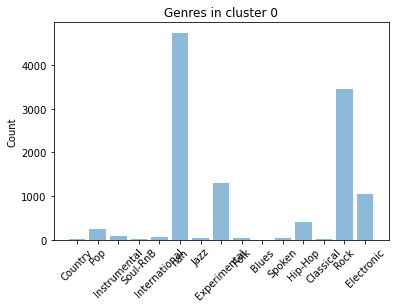

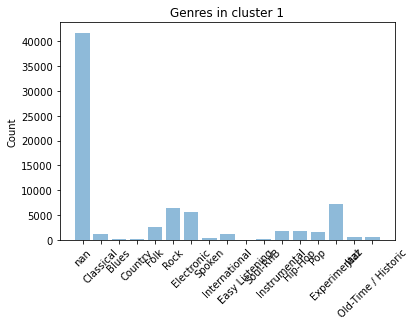

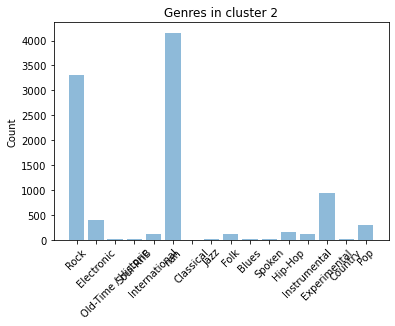

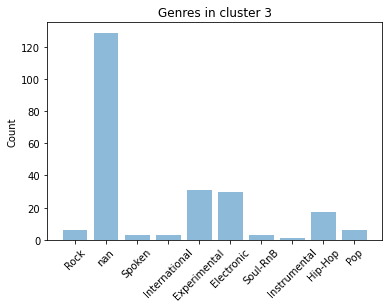

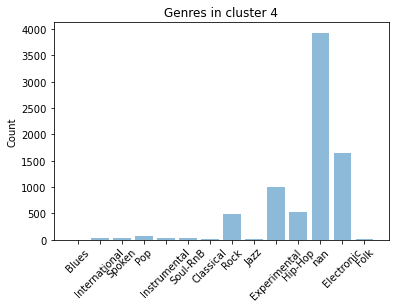

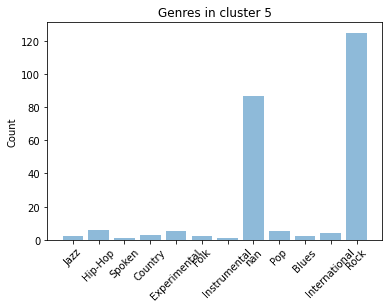

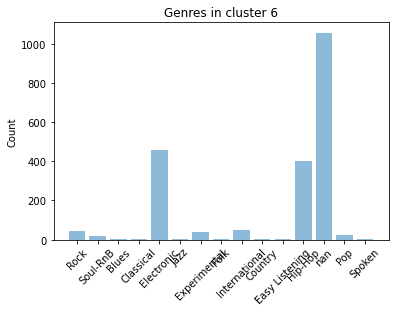

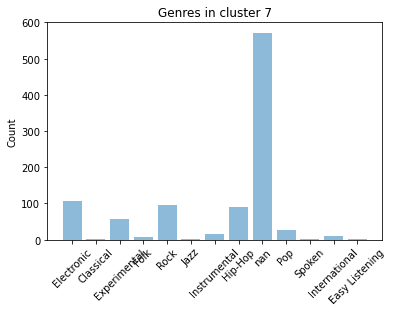

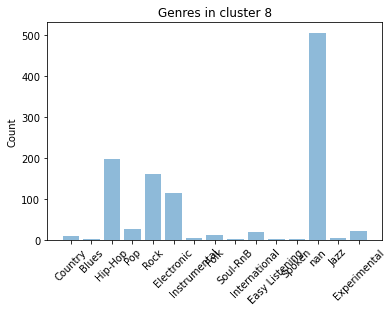

In [43]:
for i in range(9):
    plot_cluster(i,dict(finalData[i]))

In [44]:
#plot a final cluster ignoring nan values
def plot_cluster_without_nan(cluster_id, count_by_genre):
    count_by_genre.pop("nan")
    genres = tuple(count_by_genre.keys())
    print(genres)
    counts = list(count_by_genre.values())
    y_pos = np.arange(len(genres))
    plt.bar(y_pos, counts, align='center', alpha=0.5)
    plt.xticks(y_pos, genres)
    plt.ylabel('Count')
    plt.title('Genres in cluster '  + str(cluster_id))
    plt.xticks(rotation=45)
    plt.show()

('Country', 'Pop', 'Instrumental', 'Soul-RnB', 'International', 'Jazz', 'Experimental', 'Folk', 'Blues', 'Spoken', 'Hip-Hop', 'Classical', 'Rock', 'Electronic')


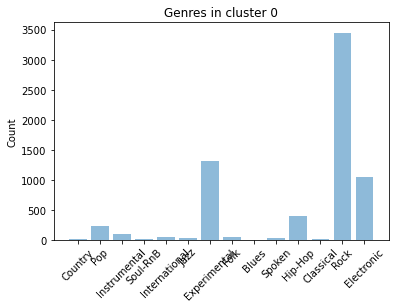

('Classical', 'Blues', 'Country', 'Folk', 'Rock', 'Electronic', 'Spoken', 'International', 'Easy Listening', 'Soul-RnB', 'Instrumental', 'Hip-Hop', 'Pop', 'Experimental', 'Jazz', 'Old-Time / Historic')


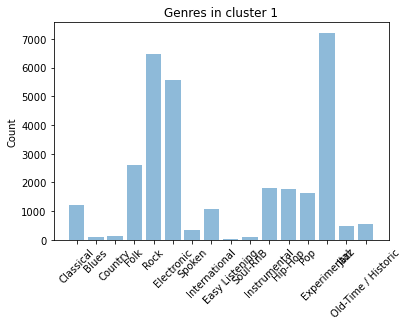

('Rock', 'Electronic', 'Old-Time / Historic', 'Soul-RnB', 'International', 'Classical', 'Jazz', 'Folk', 'Blues', 'Spoken', 'Hip-Hop', 'Instrumental', 'Experimental', 'Country', 'Pop')


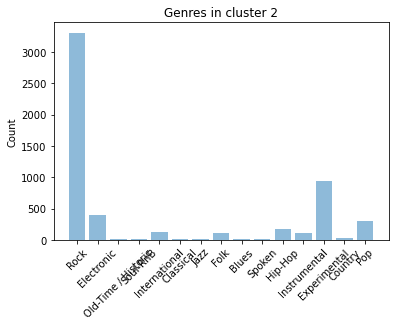

('Rock', 'Spoken', 'International', 'Experimental', 'Electronic', 'Soul-RnB', 'Instrumental', 'Hip-Hop', 'Pop')


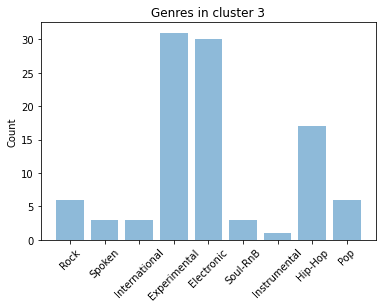

('Blues', 'International', 'Spoken', 'Pop', 'Instrumental', 'Soul-RnB', 'Classical', 'Rock', 'Jazz', 'Experimental', 'Hip-Hop', 'Electronic', 'Folk')


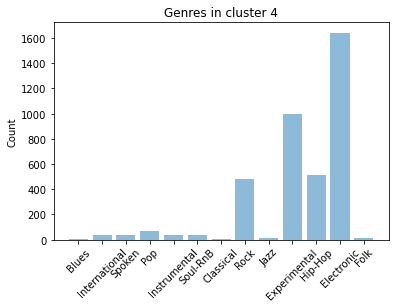

('Jazz', 'Hip-Hop', 'Spoken', 'Country', 'Experimental', 'Folk', 'Instrumental', 'Pop', 'Blues', 'International', 'Rock')


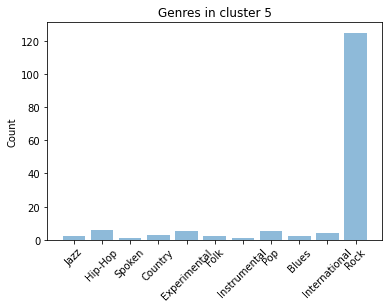

('Rock', 'Soul-RnB', 'Blues', 'Classical', 'Electronic', 'Jazz', 'Experimental', 'Folk', 'International', 'Country', 'Easy Listening', 'Hip-Hop', 'Pop', 'Spoken')


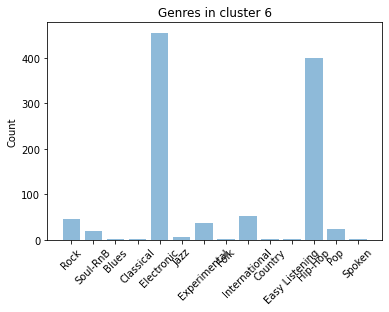

('Electronic', 'Classical', 'Experimental', 'Folk', 'Rock', 'Jazz', 'Instrumental', 'Hip-Hop', 'Pop', 'Spoken', 'International', 'Easy Listening')


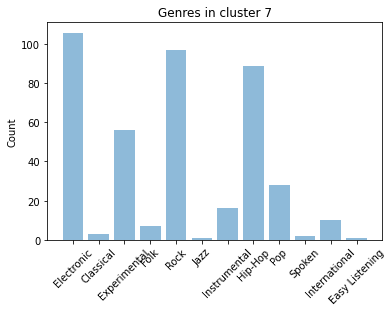

('Country', 'Blues', 'Hip-Hop', 'Pop', 'Rock', 'Electronic', 'Instrumental', 'Folk', 'Soul-RnB', 'International', 'Easy Listening', 'Spoken', 'Jazz', 'Experimental')


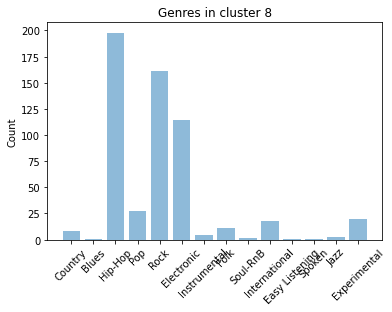

In [45]:
for i in range(9):
    plot_cluster_without_nan(i,dict(finalData[i]))